## Tokenizing and "Count Vectorizing" Text
#### In this notebook, I will process the text data to each movie, doing final cleaning of punctuation, making all words lowercase and spliting text into individual word "tokens" (N.B., for those who are text processing-savvy, this was done outside of Vectorizers in order to retain the '-', since curse words are represented in these reviews as s--t and f--k. The frequency with which curse words appear in reviews may be an important text feature for parents...).

#### The first vectorizer I will explore is Count Vectorizer. Count Vectorizer will take the simple frequency of words found in text associated with each movie and turn it into that movie's "word vector." Movies with similar word vectors will be judged to be similar. To favor words that appear to be associated with movies in general and to reduce the dimensionality of our word vector space, I will run the word vectors through a process called Truncated SVD. Truncated SVD is a method designed to capture the most variance in our collected movie word vectors in the fewest dimensions possible by taking orthogonal components through our vector space, each of which is a combination of words. I will then analyze these components to see if I can derive some meaning for some of them (see below).

#### Once we get our text data into truncatedSVD format, we will then use cosine similarity to determine which movies are most similar to which other movies in our data set. We will then also incorporate non-text data to see how this improves our cosine similarity-based similarity matrix (see Notebook 7).

### Load Movie Text Data

In [1]:
import pandas as pd
import numpy as np
import requests, re, json, copy
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import process

/Users/yukiharuhadeishi/anaconda3/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Load json of movies_features_text
with open('data/movies_features_text.json') as json_file:  
    movies_features_text = json.load(json_file)

In [3]:
df = pd.DataFrame(movies_features_text)
df.head()

,movie_id,slug,text,title
0,0,sicario-day-of-the-soldado,Families can talk about Sicario: Day of the So...,Sicario: Day of the Soldado
1,1,damsel,Families can talk about Damsel use of violenc...,Damsel
2,2,distorted,Families can talk about the rapid-fire disturb...,Distorted
3,3,the-catcher-was-a-spy,Families can talk about Berg sexual orientati...,The Catcher Was a Spy
4,4,boundaries,Families can talk about how Boundaries portray...,Boundaries


In [4]:
def get_movie_list(last_movie):
    for movie_num in range(last_movie):
        movie_titles = movies_features_text[movie_num]['title']
        return movie_titles

In [5]:
movies_features_text[0]['text'][:380]

'Families can talk about Sicario: Day of the Soldado  violence. Which parts were gruesome, and which were exciting? How did the movie achieve these effects? What  the impact of media violence on kids?  How are drinking, smoking, and drugs depicted? Are they glamorized? Does the movie make the drug business look alluring?  What does the movie have to say about law versus justice?'

In [6]:
stopwords = set(stopwords.words('english'))
# Remove punctuation from all text of each movie and remove stopwords
def clean_text_for_movie(text):
    '''
    Takes in all text of a single movie, makes lowercase and removes punctuation and stopwords
    from text. Returns words in input text as a single string, w/o English stopwords.
    '''
    words = re.sub("[^a-zA-Z\-]", " ", text).lower().split()  # removes punctuation, makes lowercase
    cleantext = [w for w in words if not w in stopwords]  # eliminates common "stop words"
    return(" ".join(cleantext))  # returns words as a string, each word separated by a space

In [7]:
clean_text_test = clean_text_for_movie(movies_features_text[0]['text'])

In [8]:
clean_text_test[:259]

'families talk sicario day soldado violence parts gruesome exciting movie achieve effects impact media violence kids drinking smoking drugs depicted glamorized movie make drug business look alluring movie say law versus justice difference two end justify means'

In [9]:
clean_text = []
def clean_text_for_movies(first_movie, num_movies_to_clean):
    print("Number of movies cleaned so far:")
    for movie in range(num_movies_to_clean):
        movie = (movie + first_movie)
        if movie % 1000 == 0:
            print(movie)
        clean_txt = clean_text_for_movie(movies_features_text[movie]['text'])
        movies_features_text[movie]['clean_text'] = clean_txt
        clean_text.append(clean_txt)
    return clean_text

In [10]:
clean_text = clean_text_for_movies(0,len(movies_features_text))

Number of movies cleaned so far:
0
1000
2000
3000
4000
5000
6000
7000
8000


In [11]:
df = pd.DataFrame(movies_features_text)
df.head()

,clean_text,movie_id,slug,text,title
0,families talk sicario day soldado violence par...,0,sicario-day-of-the-soldado,Families can talk about Sicario: Day of the So...,Sicario: Day of the Soldado
1,families talk damsel use violence intense freq...,1,damsel,Families can talk about Damsel use of violenc...,Damsel
2,families talk rapid-fire disturbing images dis...,2,distorted,Families can talk about the rapid-fire disturb...,Distorted
3,families talk berg sexual orientation presente...,3,the-catcher-was-a-spy,Families can talk about Berg sexual orientati...,The Catcher Was a Spy
4,families talk boundaries portrays drugs drug u...,4,boundaries,Families can talk about how Boundaries portray...,Boundaries


#### Movies_features_text now has two new features, one of which contains the list of words used in movie reviews and other text associated with each of our 8625 unique movies and a second list that contains a list of bigrams of these words, to capture names of actors, separated by sentence. movies_fetures_text is now ready for vectorization.

### Vectorize text for NLP
#### I will initially use a tool called Count Vectorizer to establish an easily interpreted simple count of unigram and bigram frequency in my dataset. I will evaluate the predictive value of Count Vectorization before and after combining it with my Non-Text Features (see Notebook 7).
#### I will also use a process called TF-IDF (Term Frequency Inverse Document Frequency) Vectorization on my text data for comparison. TF-IDF gives the frequency of each word in the words associated with each movie (termed a "document") normalized by the frequency with which that word appears in all of the documents combined.
#### After Count or TD-IDF vectorization, I will then use truncated SVD on text data alone to reduce the number of features to reduce overfitting. The components that result from truncated SVD will be examined to identify discernable patterns.

In [12]:
vec = CountVectorizer(analyzer = "word",
                      tokenizer = None,      # tokenized in preprocessing
                      preprocessor = None,
                      stop_words = None,     # english stop words already removed, to retain -
                      min_df = 2,            # to eliminate typos
                      max_df = .9,           # to eliminate the word "movie"
                      max_features = 100000) 

data_features = pd.SparseDataFrame(vec.fit_transform(clean_text),
                                   columns=vec.get_feature_names(),
                                   default_fill_value=0)

In [13]:
data_features.shape   # unigrams only (far too many features with larger ngrams)

(8625, 42188)

In [14]:
feature_names = vec.get_feature_names()

In [19]:
len(feature_names)

42188

## Code bits for Future Pre-Modeling and Analysis
### Investigative EDA - Pre-Modeling
    Things to look for:
      Global token counts
      Select words of interest

In [15]:
# vectorizer = CountVectorizer(min_df=2, max_df=.9)  # min_df = 2 eliminates typos,
#             # max_df = .9 eliminates the word "movie"

### Put Vectorized Data in DF for Analysis
- Sum aggregate token counts
- Plot / investigate
  - Histogram
  - Horizontal Barplot

In [22]:
text = pd.DataFrame.to_dense(data_features)

In [23]:
sum_text = text.sum()

In [53]:
sum_text.sort_values(ascending=False)[6:240]

kids           12521
violence       12004
story          11185
man            10445
language        9920
sex             9735
life            9401
even            9375
make            9045
shown           8903
family          8796
people          8572
scenes          8237
two             8205
young           8013
including       7955
well            7671
many            7625
much            7620
think           7591
good            7511
time            7418
woman           7267
get             7260
sexual          7173
way             7164
scene           6922
though          6823
strong          6691
drinking        6574
               ...  
social          2203
live            2186
years           2179
killed          2175
ways            2166
tv              2165
human           2159
point           2149
kissing         2147
christmas       2136
original        2134
mostly          2124
daughter        2123
documentary     2122
despite         2117
smoke           2104
every        

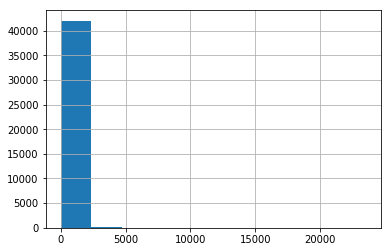

In [25]:
sum_text.hist()

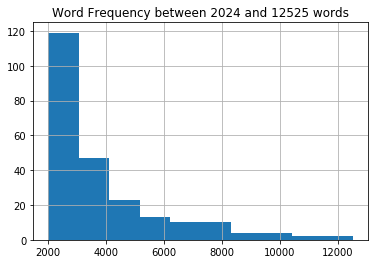

In [59]:
fig, ax = plt.subplots()
mask = sum_text.between(2024, 12525)
sum_text[mask].sort_values(ascending=False).hist()
ax.set_title("Word Frequency between 2024 and 12525 words");

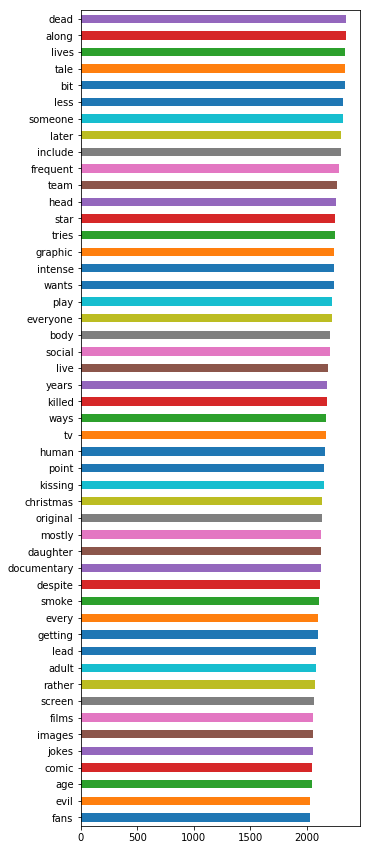

In [60]:
sum_text[mask].sort_values(ascending=True)[1:50].plot(kind="barh", figsize=(5, 15));

### Count Vectorize Text

In [58]:
data_features.shape  # unigrams only (far too many features with larger ngrams)

(8625, 42188)

In [ ]:
# text = pd.DataFrame(data_features.toarray(), columns=vectorizer.get_feature_names())

### TF-IDF Vectorizer
#### This vectorizer will vectorizes words in text by count, normalizing word frequency by including a factor that will decrease the effect of commonly occuring words specific to the posts analyzed. This is done for reasons similiar to why we discount words that occur frequently in the English language generally--- their appearance may obscure more important, differentiating words.

In [ ]:
# tvec = TfidfVectorizer(analyzer = "word",
#                        tokenizer = None,      # tokenized in preprocessing
#                        preprocessor = None,
#                        stop_words = None,     # english stop words already removed, to retain -
#                        min_df = 2,            # to eliminate typos
#                        max_df = .9,           # to eliminate the word "movie"
#                        max_features = 42164) 
# 
# data_features_tfidf = pd.SparseDataFrame(tvec.fit_transform(clean_text),
#                                           columns=tvec.get_feature_names(),
#                                           default_fill_value=0)

In [ ]:
# data_features_tfidf.shape

In [ ]:
# feature_names = tvec.get_feature_names()

In [ ]:
### Consider stemming, to avoid 'abandon', 'abandoned', 'abandoning', 'abandonment',
### and 'abandons' all ending up as separate words, etc...

In [ ]:
### investigate top word choices--- how to 

In [ ]:
# feature_names

In [ ]:
# len(feature_names)

### Truncated SVD
#### To generate vectors that encapsulate the most variance in our text data in the fewest number of components.

In [ ]:
# svd = TruncatedSVD(n_components=1000)

#### Uncomment cells below and run, to find TruncatedSVD1000 results for CountVectorized words

In [ ]:
# # countvec_truncated is fit_transformed w/1000 components
# countvec_truncated = svd.fit_transform(data_features)

In [ ]:
# countvec_truncated.shape

In [ ]:
# components_countvec = pd.DataFrame(svd.components_.T, index=feature_names)

In [ ]:
# components_countvec   # columns are svd components, 0 - 999, for count vectorized words

In [ ]:
# components_countvec.shape

In [ ]:
# tfidf_truncated = svd.fit_transform(data_features_tfidf)

In [ ]:
# tfidf_truncated.shape

In [ ]:
# components_tfidf = pd.DataFrame(svd.components_.T, index=feature_names)

In [ ]:
# components_tfidf   # columns are svd components, 0 - 999, for tf-idf vectorized words

In [ ]:
# components_tfidf.shape

#### Explore components--- list actual numerical value, but print head(10) and tail(10) for important components

In [ ]:
word_importance_by_component = []

In [ ]:
# word_importance_component_1 = components_tfidf[0].abs()
# word_importance_component_1

In [ ]:
# type(word_importance_component_1)

In [ ]:
# word_importance_component_1.index   ### Take word order from abs(), but list actual value!!

In [ ]:
# word_importances_tfidf = []

In [ ]:
# svd_explained_variance = svd.explained_variance_

In [ ]:
cum_sum_explained_variance = []
def cum_sum_explained_var(vect, total_comp):
    cum_sum_explained_variance = []
    if total_comp > len(vect.explained_variance_):
        print("That's too many components. Max_components is 1000\.\n")
        total_comp = int(input("Enter new total_components:"))
    else:
        pass
    cum_sum_var = 0
    for i in range(total_comp):
        cum_sum_var += vect.explained_variance_[i]
        cum_sum_explained_variance.append(cum_sum_var)
    return cum_sum_explained_variance

In [ ]:
# cum_sum_explained_var(svd, 1000)

In [ ]:
# data_features_tfidf.shape[1]

In [ ]:
## pd.DataFrame(index=feature_names, columns=components_tfidf)
## tfidf_features['feature names'] = vocab
## #pd.DataFrame(features_components_tfidf

In [ ]:
# print(vocab)

### Cosine Similarity:  TFIDF_truncSVD700

In [ ]:
### Calcualte as matrix of all movies to all movies of  countvec_truncated
sim_matrix_countvec_truncSVD700 = cosine_similarity(countvec_truncated, countvec_truncated)

In [ ]:
# similarity_matrix_countvec_truncSVD1000 = pd.DataFrame(sim_matrix_countvec_truncSVD700,
                                                columns=df['title'],
                                                index=df['title'])

In [ ]:
# similarity_matrix_countvec_truncSVD1000.head()

In [ ]:
# similarity_matrix_countvec_truncSVD1000['Damsel']

In [ ]:
### Calculate as matrix of all movies to all movies of tfidf_truncated 
# sim_matrix_tfidf_truncSVD700 = cosine_similarity(tfidf_truncated, tfidf_truncated)

In [ ]:
# similarity_matrix_tfidf_truncSVD700 = pd.DataFrame(sim_matrix_tfidf_truncSVD700,
#                                                    columns=df['title'],
#                                                    index=df['title'])

In [ ]:
# similarity_matrix_tfidf_truncSVD700.head()

In [ ]:
# similarity_matrix_tfidf_truncSVD700['Damsel']

### Find Similar Movies

In [ ]:
movie_list = df['title']

In [ ]:
def title_recommender(movie_name, movie_list, limit=3):
    results = process.extract(movie_name, movie_list, limit=limit)
    return results

In [ ]:
def find_similar_movies():
    movie_name = input("Give me a movie title and I'll give you five titles you might also like:")
    for title in df['title']:
        if title == movie_name:
            sim_movies_text = similarity_matrix_countvec_truncSVD1000[movie_name]
            print("Thanks! Here are my recommendations, along with review text similarity scores:")
            return sim_movies_text.sort_values(ascending=False)[1:6]
    limit = 3
    while title != movie_name:
        results = title_recommender(movie_name, df['title'], limit=limit)
        print("Sorry, that movie title isn't in my list. Did you mean", results, "?")
        movie_name = input("(I need the exact title, please...)")
        for title in df['title']:
            if title == movie_name:
                sim_movies_text = similarity_matrix_countvec_truncSVD1000[movie_name]
                print("Thanks! Here are my recommendations, along with review text similarity scores:")
                return sim_movies_text.sort_values(ascending=False)[1:6]
        limit += 1
        if limit >= 10:
            limit = 10

In [ ]:
find_similar_movies()

In [ ]:
find_similar_movies2()

#### As you can see above, recommendations are usually good, with some notable exceptions. Informal analyses show recommendations are accurate approximately 80-85% of the time. Unfortunately, this recommender will not work without the cosine similarity matrix, which is prohibitively large to upload to GitHub. In order to generate this file, you can either run the notebooks in this repo in order, or recompile the matrix from the 15 pieces that I've generated and uploaded as simmat0, simmat1, ..., simmat14. You can do so by executing the function at the bottom of notebook 5.1.